<a href="https://colab.research.google.com/github/JorgeAcebes/TESS_UAM/blob/main/TESS_LCF_FFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install lightkurve --quiet # Descomentar cuando empiece de nuevo
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import os
from lightkurve.correctors import PLDCorrector

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[h

/usr/local/lib/python3.12/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [4]:
#Nombre de la estrella
target_name  = "Pi Mensae"
min_exp_time = 120
max_exp_time = 200


In [7]:
def filter_search(target_name):
    search_ffi = lk.search_tesscut(target_name)
    search_tpf = lk.search_targetpixelfile(target_name)
    search_lcf = lk.search_lightcurve(target_name)
    return search_ffi, search_tpf, search_lcf



def apply_filters(search, min_exp_time = None, max_exp_time = None, author = None):

    filtered = search

    # Filtrado por exposición mínima y máxima
    if min_exp_time is not None:
        filtered = filtered[filtered.exptime.value >= min_exp_time]

    if max_exp_time is not None:
        filtered = filtered[filtered.exptime.value <= max_exp_time]

    # Filtrado por autor
    if author is not None and "author" in filtered.table.colnames:
        filtered = filtered[filtered.author == author]

    return filtered



In [8]:
ffi_search,tpf_search,lcf_search = filter_search(target_name)

ffi = apply_filters(ffi_search)
tpf = apply_filters(tpf_search)
lcf = apply_filters(lcf_search)



print(f'Full frame image: {ffi}\n\n Target pixel files: {tpf} \n\n Light Curve files: {lcf}')

Full frame image: SearchResult containing 25 data products.

 #     mission     year  author exptime target_name distance
                                   s                 arcsec 
--- -------------- ---- ------- ------- ----------- --------
  0 TESS Sector 04 2018 TESScut    1426   Pi Mensae      0.0
  1 TESS Sector 01 2018 TESScut    1426   Pi Mensae      0.0
  2 TESS Sector 13 2019 TESScut    1426   Pi Mensae      0.0
  3 TESS Sector 11 2019 TESScut    1426   Pi Mensae      0.0
  4 TESS Sector 12 2019 TESScut    1426   Pi Mensae      0.0
  5 TESS Sector 08 2019 TESScut    1426   Pi Mensae      0.0
  6 TESS Sector 27 2020 TESScut     475   Pi Mensae      0.0
  7 TESS Sector 31 2020 TESScut     475   Pi Mensae      0.0
  8 TESS Sector 28 2020 TESScut     475   Pi Mensae      0.0
  9 TESS Sector 39 2021 TESScut     475   Pi Mensae      0.0
 10 TESS Sector 38 2021 TESScut     475   Pi Mensae      0.0
 11 TESS Sector 34 2021 TESScut     475   Pi Mensae      0.0
 12 TESS Sector 35 2021 

In [15]:
author = 'SPOC'
idx = 0  # Para seleccionar qué tránsito quiero escoger
wdw_len = 1001  # Longitud de ventana para flatten
sgm =4 # Sigma value para clipped

ffi = apply_filters(
    ffi_search,
    min_exp_time=min_exp_time,
    max_exp_time=max_exp_time,
    author=author
    )

tpf = apply_filters(
    tpf_search,
    min_exp_time=min_exp_time,
    max_exp_time=max_exp_time,
    author=author
    )

lcf = apply_filters(
    lcf_search,
    min_exp_time=min_exp_time,
    max_exp_time=max_exp_time,
    author=author
    )




lcf = lcf.download_all()

# Tránsito a Partir de LCF

In [16]:
# Compruebo si puedo utilizar PDCSAP o no
if hasattr(lcf[idx], 'pdcsap_flux'):
    print("Puedo utilizar pdcsap_flux")
else:
    print("Tengo que utilizar sap_flux")


Puedo utilizar pdcsap_flux


Check where the plot has jitter to erase it, in case there is


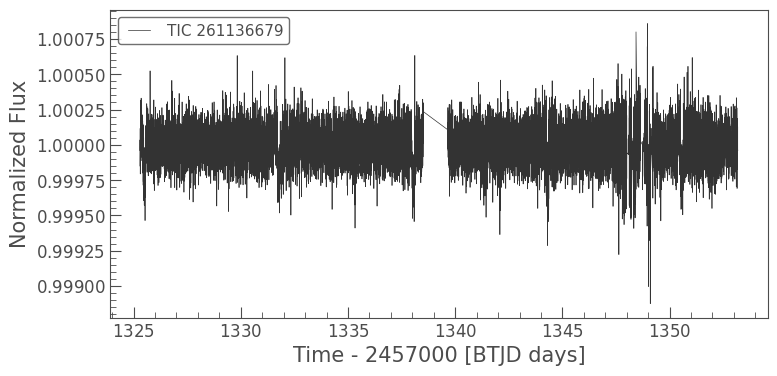

In [17]:
pdc_fx =lcf[idx].pdcsap_flux
# sap_fx =lcf[0].sap_flux

flat_lc = lcf[idx].flatten(window_length=wdw_len)
flat_lc.plot();
print('Check where the plot has jitter to erase it, in case there is')

In [18]:
# erasing the jitter in case there is

def erase_jitter(lc, j_start, j_end):
  mask = (lc.time.value < j_start) | (lc.time.value > j_end)
  mask_lc = lc[mask]
  return mask_lc

# MODIFICA ESTOS NÚMEROS EN FUNCIÓN DE DÓNDE HAY MÁS Jitter
j1 = 1346
j2 = 1350

flat_lc = erase_jitter(flat_lc, j1, j2)

<Figure size 800x500 with 0 Axes>

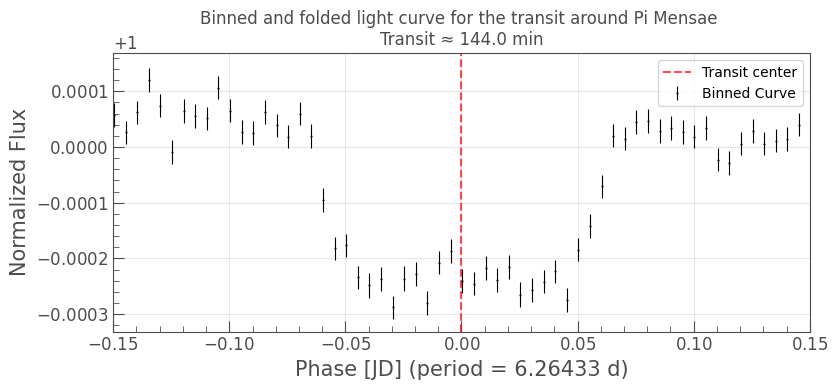

In [19]:
clipped_lc=flat_lc.remove_outliers(sigma=sgm)

'''
# El BLS busca dips periódicos (caídas de brillo) que podrían corresponder a tránsitos.
Para eso:

Prueba muchos periodos posibles (por ejemplo, desde 0.1 a 30 días).

Para cada periodo, pliega la curva de luz.

En la curva plegada, ajusta un modelo tipo caja: flujo constante → caída → flujo constante.

Mide qué tan bien encaja esa forma de caja en los datos (menor χ² o mayor potencia).
'''
# Encuentra el periodo automáticamente y doblamos el lightcurve

norm_lc = clipped_lc / np.median(clipped_lc.flux)

bls = norm_lc.to_periodogram(method='bls')
period = bls.period_at_max_power
epoch_time = bls.transit_time_at_max_power
duration = bls.duration_at_max_power.to(u.minute)
folded_lc = clipped_lc.fold(period=period, epoch_time=epoch_time)
binned_lc = folded_lc.bin(time_bin_size=duration * 0.05)
dur_days = duration.to(u.day).value

plt.figure(figsize=(8, 5))
binned_lc.errorbar(
    marker='.',
    lw=0.8,
    markersize=1,
    color='k',
    label='Binned Curve')

plt.axvline(
    0,
    color='r',
    linestyle='--',
    alpha=0.7,
    label='Transit center'
)


plt.xlim(-1.5 * dur_days, 1.5 * dur_days)
plt.xlabel('Phase [JD] (period = {:.5f} d)'.format(period.value))
plt.ylabel('Normalized Flux')
plt.title(f'Binned and folded light curve for the transit around {target_name} \nTransit ≈ {duration.value:.1f} min')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tránsito a partir de FFI

Busca en el 2º gráfico si tienes jitter (lo más seguro) borrar en el siguiente paso


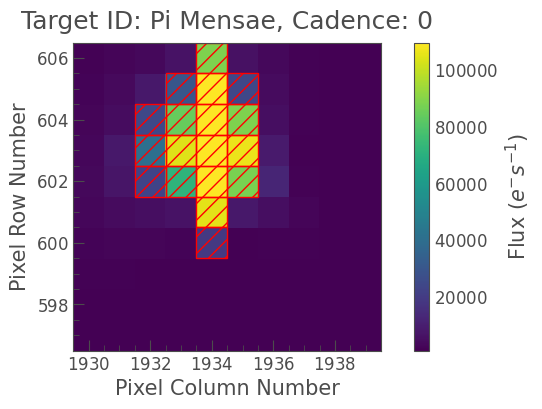

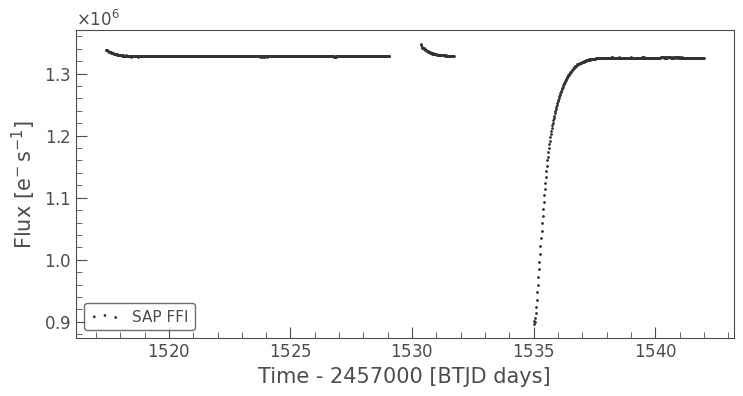

In [ ]:
idx=5
ffi_data = search_ffi[idx].download(cutout_size=10)

max_flux_idx = np.unravel_index(np.argmax(ffi_data.flux[idx]), ffi_data.flux[idx].shape)
target_mask = ffi_data.create_threshold_mask(threshold=10, reference_pixel=max_flux_idx)
ffi_data.plot(aperture_mask=target_mask, mask_color='r');

print('Busca en el 2º gráfico si tienes jitter (lo más seguro) borrar en el siguiente paso')
ffi_lc = ffi_data.to_lightcurve(aperture_mask=target_mask)
ffi_lc.scatter(label='SAP FFI');



<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

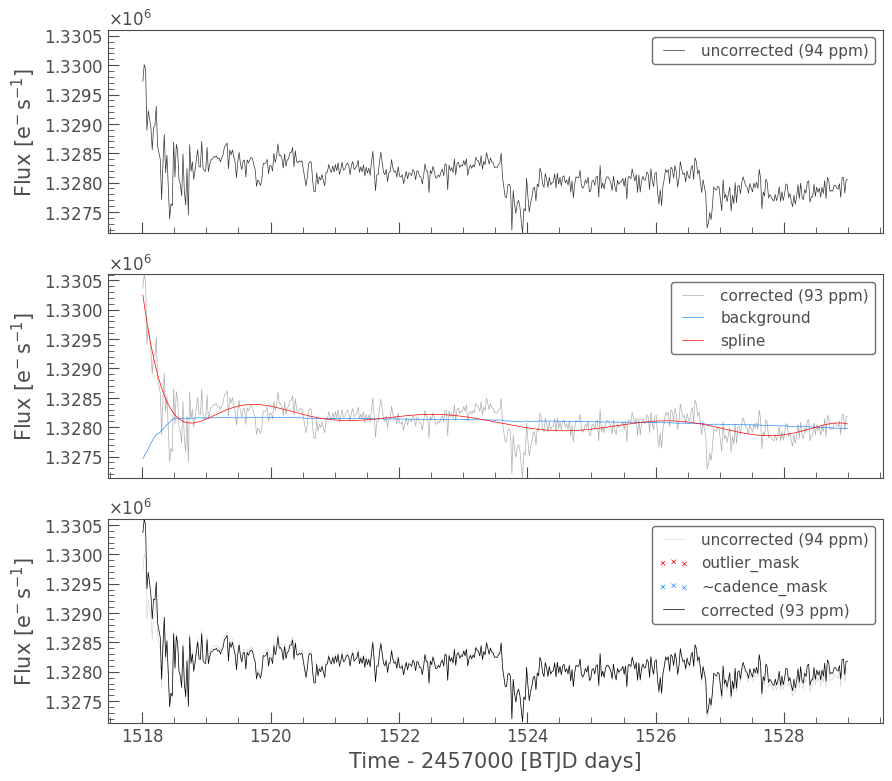

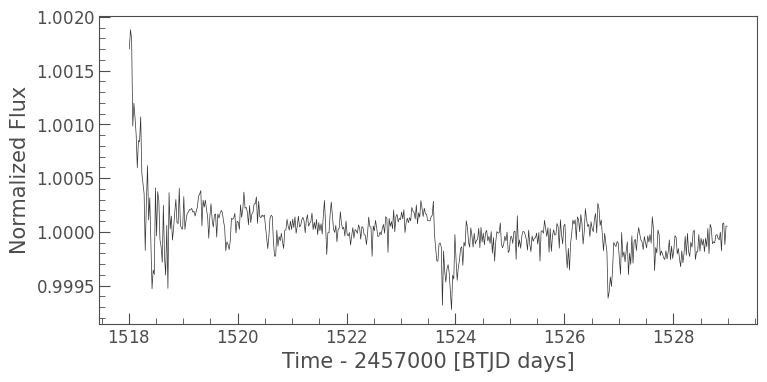

In [ ]:
j_0 = 1518  # Inicio del 1er segmento bueno
j_1 = 1529  # Final del 1er segmento bueno
j_2 = 1529  # Inicio del 2do segmento bueno (después del gap)
j_3 = 1529  # Final del 2do segmento / Inicio del 3er segmento

# Mantener SOLO los tres segmentos buenos
mask_ffi = (
    (ffi_lc.time.value >= j_0) & (ffi_lc.time.value <= j_1)   # Segmento 1
    # |(ffi_lc.time.value >= j_2) & (ffi_lc.time.value <= j_3)    # Segmento 2
    #  | (ffi_lc.time.value >= j_2) & (ffi_lc.time.value <= 1440)    # Segmento 3
)


masked_lc_ffi = ffi_lc[mask_ffi]

pca_comp=1 #Número de tendencias a eliminar

pld = PLDCorrector(ffi_data[mask_ffi], aperture_mask=target_mask)
pld.correct(pca_components=pca_comp)
pltAxis = pld.diagnose()

corrected_ffi = pld.correct(pca_components=pca_comp)

ffi_flat_lc = corrected_ffi.flatten(window_length=wdw_len)
ffi_flat_lc.plot()




<Figure size 800x500 with 0 Axes>

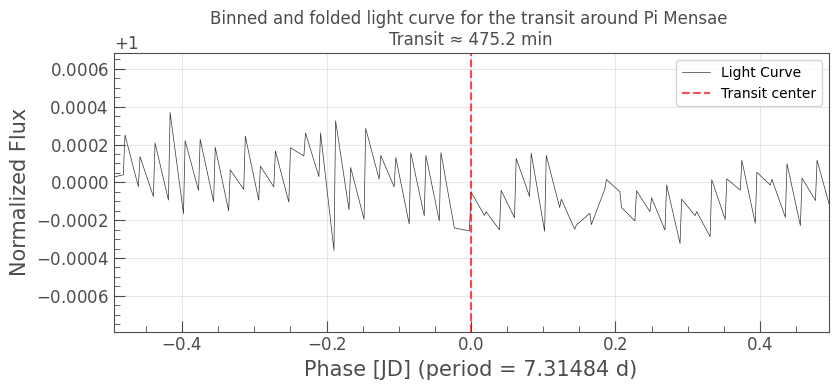

In [ ]:
ffi_flat_lc = corrected_ffi.flatten(window_length=wdw_len)
ffi_clipped_lc=ffi_flat_lc.remove_outliers(sigma=sgm)


bls = ffi_lc.to_periodogram(method='bls')
period = bls.period_at_max_power
epoch_time = bls.transit_time_at_max_power
duration = bls.duration_at_max_power.to(u.minute)
ffi_folded_lc = ffi_clipped_lc.fold(period=period, epoch_time=epoch_time)
dur_days = duration.to(u.day).value

plt.figure(figsize=(8, 5))
ffi_folded_lc.plot(label='Light Curve')
plt.axvline(
    0,
    color='r',
    linestyle='--',
    alpha=0.7,
    label='Transit center'
)


plt.xlim(-1.5 * dur_days, 1.5 * dur_days)
plt.xlabel('Phase [JD] (period = {:.5f} d)'.format(period.value))
plt.ylabel('Normalized Flux')
plt.title(f'Binned and folded light curve for the transit around {target_name} \nTransit ≈ {duration.value:.1f} min')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show();
